# **Actividad 4**:

En esta última actividad aprenderemos cómo implementar una Recurrent Neural Network (RNN) y un Long-Short Term Memory (LSTM) para procesar datos de series temporales. En la segunda parte de la actividad, usaremos una RNN para procesar y generar texto como si fuéramos Shakespeare.

**EVALUACIÓN**: En esta cuarta práctica, tendreis completar el esqueleto del notebook y redactar un informe de 2/3 páginas explicando:
* Las arquitecturas implementadas y la justificación de las decisiones de diseño.
* El impacto del uso de un LSTM en vez de una RNN y un MLP.
* Los desafíos encontrados durante la implementación y cómo se resolvieron.

La nota de la actividad esta divida en un 50% para la evaluación del notebook y un 50% para la evaluación del informe.

# Data Loading
**Tarea 1**: Genera un dataset sintético de series temporales.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
keras.utils.set_random_seed(555)

def generate_time_series(batch_size, n_steps):
       freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
       time = np.linspace(0, 1, n_steps)
       series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
       series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
       series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
       return series[..., np.newaxis].astype(np.float32)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

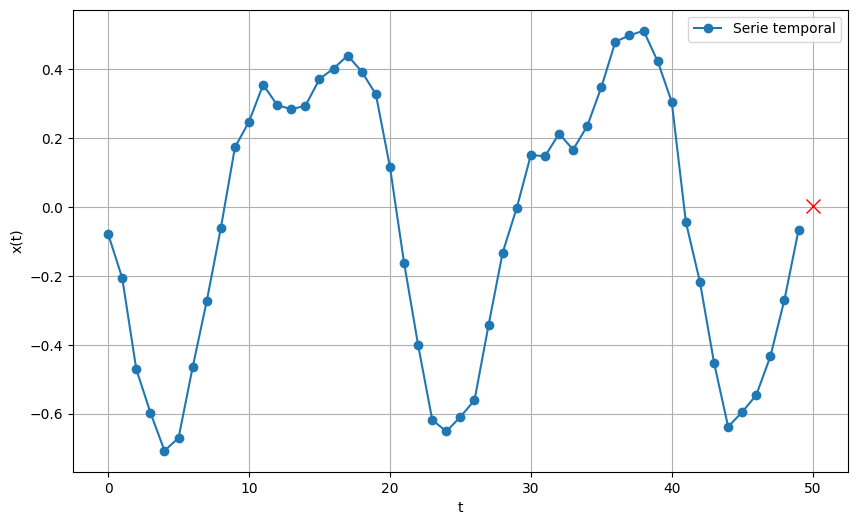

In [ ]:
time = np.arange(n_steps + 1)
plt.figure(figsize=(10, 6))
plt.plot(time[:-1], X_valid[0], marker='o', label='Serie temporal')
plt.plot(time[-1], y_valid[0], marker='x', markersize=10, color='red')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.legend()
plt.grid(True)
plt.show()

Nuestro punto de referencia, que utilizamos para evaluar las arquitecturas, es el **naive forecasting**, que dada una serie temporal predice el último valor de la serie. En este caso, nos da un error cuadrático medio de 0.020910554.

In [ ]:
y_pred = X_valid[:, -1]
baseline = np.mean(keras.losses.mean_squared_error(y_valid, y_pred))
baseline

0.020910554

# One step forecasting

En esta primera parte, nuestro objetivo es predecir el siguiente valor de una serie temporal. El propósito es implementar y comparar distintas arquitecturas: un MLP, una Deep RNN y una LSTM.

## MLP

**Tarea 2**: Implementa y entrena un Perceptrón Multicapa (MLP) para la predicción de series temporales. Prueba distintas configuraciones y muestra los resultados en un plot, comparandolas con el baseline.

* Define una capa de Flatten con input_shape = [n_steps, 1].

* Añade capas Dense, siendo la última capa compuesta por una neurona.


In [ ]:
"""
[TIPS]
model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[n_steps, 1]),
])
"""
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

# Definición del modelo MLP
mlp_model = Sequential([
    Flatten(input_shape=[n_steps, 1]),
    Dense(20, activation="relu"),
    Dense(10, activation="relu"),
    Dense(1)
])

# Compilar el modelo
mlp_model.compile(loss="mse", optimizer=Adam())

# Entrenamiento del modelo
history = mlp_model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0566 - val_loss: 0.0140
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0113 - val_loss: 0.0089
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0074 - val_loss: 0.0066
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/st

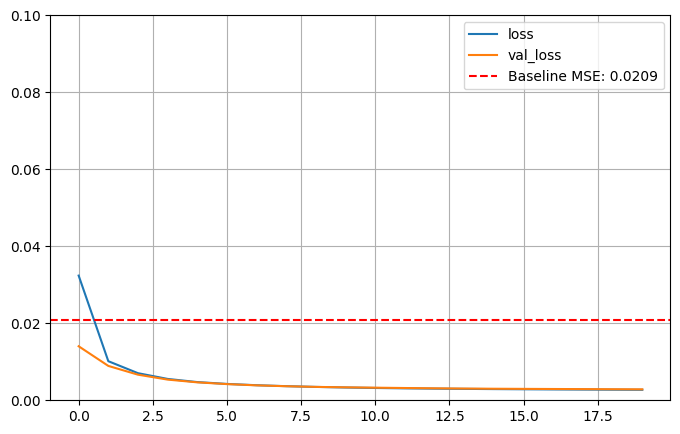

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.axhline(y=baseline, color='r', linestyle='--', label=f'Baseline MSE: {baseline:.4f}')
plt.gca().set_ylim(0, 0.1) # set the vertical range to [0-1]
plt.legend()
plt.show()

## RNN

```
 model = keras.models.Sequential([
     keras.layers.SimpleRNN(1, input_shape=[None, 1])
])
```

Con Keras, esta es la RNN más simple que puedes construir. Solo contiene una capa con una sola neurona. No necesitamos especificar la longitud de las secuencias de entrada (a diferencia del MLP), ya que una red neuronal recurrente puede procesar cualquier número de pasos temporales (por eso establecemos la primera dimensión de entrada en None).

Por defecto, la capa **SimpleRNN** utiliza la función de activación tangente hiperbólica (tanh). El funcionamiento de esta capa es el mismo que se explica en el temario.
1. El estado inicial h0 se establece en 0 y se pasa a una única neurona recurrente, junto con el valor del primer paso temporal, x(0).
2. La neurona calcula una suma ponderada de estos valores y aplica la función de activación tangente hiperbólica al resultado, lo que da la primera salida, y0. En una RNN simple, esta salida también es el nuevo estado h0.
3. Este nuevo estado se pasa a la misma neurona recurrente junto con el siguiente valor de entrada, x(1), y el proceso se repite hasta el último paso temporal. Luego, la capa simplemente da salida al último valor. Todo esto se realiza simultáneamente para cada serie temporal.

**Tarea 3**: Implementa una Deep RNN para predicción de series temporales, y compara su resultado con el MLP y el baseline. Prueba distintas configuraciones (capas, número de neuronas recurrentes). Muestra en un plot los resultados de las distintas configuraciones, comparandolos con el MLP y el baseline.

En las capas intermedias de la Deep RNN, establecemos el parámetro `return_sequences` en True, para que la capa devuelva la secuencia completa en lugar de solo el último output `y`.






In [ ]:
"""
[TIPS]
keras.layers.SimpleRNN(n_neuronas, return_sequences=True, input_shape=[None, 1]),
])
"""
from keras.layers import SimpleRNN, Dense
from keras.optimizers import Adam
# Definición del modelo Deep RNN
deep_rnn_model = Sequential([
    SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    SimpleRNN(20, return_sequences=True),
    SimpleRNN(20),
    Dense(1)
])

# Compilar el modelo
deep_rnn_model.compile(loss="mse", optimizer=Adam())

# Entrenamiento del modelo
history = deep_rnn_model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: 0.1142 - val_loss: 0.0070
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0051 - val_loss: 0.0037
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/

## LSTM

**Tarea 4**: Implementa una Deep LSTM para predicción de series temporales, y compara su resultado con la RNN, el MLP y el baseline. Prueba distintas configuraciones, justificando tus decisiones.

```
lstm = keras.layers.LSTM(4, return_sequences=True, return_state=False)
```


In [ ]:
from keras.layers import LSTM, Dense, Flatten
# Definición del modelo Deep LSTM
deep_lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=[None, 1]),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])

# Compilar el modelo
deep_lstm_model.compile(loss="mse", optimizer=Adam())

# Entrenamiento del modelo
history_lstm = deep_lstm_model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 84ms/step - loss: 0.0589 - val_loss: 0.0188
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - loss: 0.0169 - val_loss: 0.0142
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - loss: 0.0136 - val_loss: 0.0118
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - loss: 0.0108 - val_loss: 0.0081
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - loss: 0.0072 - val_loss: 0.0040
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 12/20
219/219 ━━━━━━━━━━

# Forecasting several times steps ahead

La opción más simple para predecir múltiples valores de la serie temporal es predecir el siguiente valor, añadirlo a la serie temporal de entrada y luego predecir el siguiente. En el caso de que queramos predecir los siguientes 10 pasos de la serie temporal, podríamos implementarlo de la siguiente manera:



In [ ]:
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
# Utilizar el modelo MLP para predecir los siguientes 10 pasos
X_mlp = X_new
for step_ahead in range(10):
    y_pred_one = mlp_model.predict(X_mlp[:, step_ahead:])[:, np.newaxis, :]
    X_mlp = np.concatenate([X_mlp, y_pred_one], axis=1)

# Obtener las predicciones
Y_pred_mlp = X_mlp[:, n_steps:]
print("MLP Predictions:", Y_pred_mlp)

# Utilizar el modelo Deep RNN para predecir los siguientes 10 pasos
X_rnn = X_new
for step_ahead in range(10):
    y_pred_one = deep_rnn_model.predict(X_rnn[:, step_ahead:])[:, np.newaxis, :]
    X_rnn = np.concatenate([X_rnn, y_pred_one], axis=1)

# Obtener las predicciones
Y_pred_rnn = X_rnn[:, n_steps:]
print("Deep RNN Predictions:", Y_pred_rnn)

# Utilizar el modelo Deep LSTM para predecir los siguientes 10 pasos
X_lstm = X_new
for step_ahead in range(10):
    y_pred_one = deep_lstm_model.predict(X_lstm[:, step_ahead:])[:, np.newaxis, :]
    X_lstm = np.concatenate([X_lstm, y_pred_one], axis=1)

# Obtener las predicciones
Y_pred_lstm = X_lstm[:, n_steps:]
print("Deep LSTM Predictions:", Y_pred_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
MLP Predictions: [[[-0.25344303]
  [-0.15253295]
  [-0.08870877]
  [-0.01176234]
  [ 0.07521011]
  [ 0.15150203]
  [ 0.19203992]
  [ 0.2582999 ]
  [ 0.31825948]
  [ 0.2899335 ]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Deep RNN Predictions: [[[-0.23809609]
  [-0.14645167]
  [-

En este caso, el error en la predicción del primer valor de la serie temporal va a ser menor que en los últimos valores, ya que el error se va acumulando.


**Tarea 5**: Re-implementa y re-entrena una Deep RNN para que prediga 10 valores en vez de un valor, y compara el resultado con la implementación anterior.


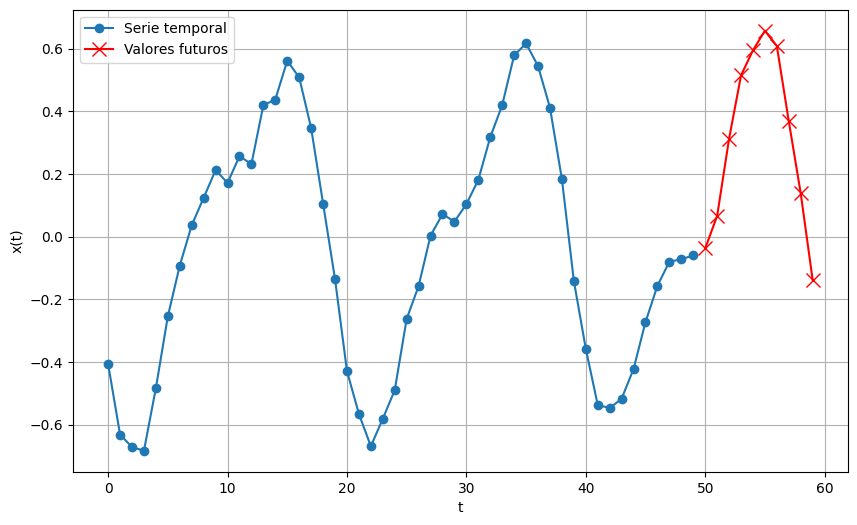

(7000, 50, 1) (7000, 10, 1)
Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - loss: 0.1287 - val_loss: 0.0389
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 0.0341 - val_loss: 0.0246
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0229 - val_loss: 0.0175
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0172 - val_loss: 0.0144
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 0.0146 - val_loss: 0.0126
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 0.0120 - val_loss: 0.0110
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0112 - val_loss: 0.0107
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.0106 - val_loss: 0.0101
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.0100 - val_loss: 0.0094
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0095 - val_loss: 0.0089
Epoch

In [ ]:
# Necesitamos ajustar los datos para que la salida del modelo contenga los próximos 10 valores
def generate_time_series(batch_size, n_steps, n_future=10):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps + n_future)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps + n_future) - 0.5)  # + noise
    return series[..., np.newaxis].astype(np.float32)

n_steps = 50
n_future = 10
series = generate_time_series(10000, n_steps, n_future)
X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]

time = np.arange(n_steps + n_future)
plt.figure(figsize=(10, 6))
plt.plot(time[:n_steps], X_valid[0], marker='o', label='Serie temporal')
plt.plot(time[n_steps:], y_valid[0], marker='x', markersize=10, color='red', label='Valores futuros')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.legend()
plt.grid(True)
plt.show()

print(X_train.shape, y_train.shape)

from keras.layers import RepeatVector, TimeDistributed

# Definición del modelo Deep RNN para predecir múltiples pasos
deep_rnn_model_multi = Sequential([
    SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    SimpleRNN(20, return_sequences=True),
    SimpleRNN(20),
    RepeatVector(n_future),
    SimpleRNN(20, return_sequences=True),
    TimeDistributed(Dense(1))
])

# Compilar el modelo
deep_rnn_model_multi.compile(loss="mse", optimizer=Adam())

# Entrenamiento del modelo
history_rnn_multi = deep_rnn_model_multi.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Resumen de los Resultados **(Comparación)**
*   Implementación Anterior (1 Paso):
  *   La MSE de prueba fue significativamente menor que el baseline y las pérdidas de entrenamiento y validación fueron bajas.

*   Nueva Implementación (10 Pasos):
  *   La pérdida inicial fue alta (0.1287) pero disminuyó rápidamente.
  *   La pérdida de validación (val_loss) se estabilizó alrededor de 0.0069, lo cual es una mejora significativa.

Aún podemos mejorar: en lugar de entrenar el modelo para predecir los próximos 10 valores solo en el último paso temporal, podemos entrenarlo para predecir los próximos 10 valores en cada paso temporal. En otras palabras, podemos convertir esta **sequence-to-vector RNN** en una **sequence-to-sequence RNN**.

La ventaja de este cambio es que la loss contendrá un término para la salida de la RNN en cada paso temporal, no solo la salida en el último paso temporal -- habrá muchos más gradientes de la loss fluyendo a través de la red neuronal. Estos gradientes no van a fluir únicamente a través del tiempo; también fluirán desde el output de cada paso temporal.

Es decir, en el paso temporal 0, el modelo producirá un vector que contiene las predicciones para los pasos temporales 1 a 10, luego en el paso temporal 1, el modelo pronosticará los pasos temporales 2 a 11, y así sucesivamente. Por lo tanto, cada objetivo debe ser una secuencia de la misma longitud que la secuencia de entrada, conteniendo un vector de 10 dimensiones en cada paso. Adaptemos los datos:










In [ ]:
Y = np.empty((10000, n_steps, 10)) # each target is a sequence of 10D vectors
for step_ahead in range(1, 10 + 1):
    Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

**Tarea 6**: Implementa y entrena una sequence-to-sequence RNN. Para ello, tendras que usar la función de Keras **TimeDistributed** (`keras.layers.TimeDistributed(keras.layers.Dense(10))`), que envuelve a la capa Dense, aplicandola a cada time step de la serie temporal de entrada. Para ello, hace un reshape de los inputs de [batch_size, time_steps, input_dimensions] a [batch_size x time_steps, input_dimensions].



In [ ]:
from keras.layers import TimeDistributed

# Definición del modelo Sequence-to-Sequence RNN
seq_to_seq_rnn_model = Sequential([
    SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    SimpleRNN(20, return_sequences=True),
    SimpleRNN(20, return_sequences=True),
    TimeDistributed(Dense(n_future))
])

# Compilar el modelo
seq_to_seq_rnn_model.compile(loss="mse", optimizer=Adam())

# Entrenamiento del modelo
history_seq_to_seq_rnn = seq_to_seq_rnn_model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.1176 - val_loss: 0.0437
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.0423 - val_loss: 0.0388
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.0386 - val_loss: 0.0371
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0365 - val_loss: 0.0349
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0340 - val_loss: 0.0332
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0326 - val_loss: 0.0326
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0316 - val_loss: 0.0318
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.0308 - val_loss: 0.0305
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.0300 - val_loss: 0.0296
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0293 - val_loss: 0.0288
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0285 - val_loss: 0.0279
Epoch 12/20
219/219 ━━━━━━━━━━━

# Actividad final: Generando texto como Shakespeare

En esta actividad final, vamos a generar texto como si fuéramos Shakespeare. Para ello, entrenaremos una RNN para resolver la tarea de **next-character prediction**. Una vez entrenada, podremos generar texto sintético (un carácter por step del modelo). Primero, carguemos los datos y preprocesemos el texto. El tokenizer codifica cada carácter con un entero (con rango entre 1 y el número de caracteres).


In [ ]:
import tensorflow as tf
from tensorflow import keras
shakespeare_url = "https://homl.info/shakespeare" # shortcut URL
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts([shakespeare_text])

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
print(tokenizer.texts_to_sequences(["First"]))
print(tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]]))
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = len(shakespeare_text)

[[20, 6, 9, 8, 3]]
['f i r s t']


In [25]:
dataset_size

1115394

In [28]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
# Crear el dataset a partir de las secuencias de enteros
train_size = int(dataset_size * 0.9)
if train_size == 0:
    raise ValueError("Train size is 0, which is not valid. Check the dataset.")
# train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

1003854

Nuestro dataset esta compuesto por una única frase de más de un milion de carácteres. Para convertir esta secuencia en múltiples ventanas de texto vamos a usar la función **window()**.

Por defecto, este método crea ventanas no solapadas, pero para obtener el conjunto de entrenamiento más grande posible, usamos shift=1 para que la primera ventana contenga los caracteres del 0 al 100, la segunda contenga los caracteres del 1 al 101, y así sucesivamente. Para asegurarnos de que todas las ventanas tengan exactamente 101 caracteres de longitud, establecemos drop_remainder=True (de lo contrario, las últimas 100 ventanas contendrán 100 caracteres, 99 caracteres, y así sucesivamente hasta 1 caracter).

In [ ]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.window(window_length, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [ ]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [ ]:
dataset = dataset.map(lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)